In [239]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import json
import glob
import itertools

from collections import defaultdict

EXPERIMENTS = ["strong_scaling", "weak_scaling", "duplicate_keys"]
EXP_TYPES = ["build", "intersect"]
MODES = ["noindex_nomanaged", "index_nomanaged", "noindex_managed", "index_managed"]

SYSTEMS = ["summit"]

# data[EXPERIMENT][EXP_TYPE][MODE]
results = dict()

%matplotlib inline
from six import iteritems
from matplotlib.lines import Line2D

fmarkers=Line2D.filled_markers

plt.style.use('ggplot')

print(EXPERIMENTS)
print(EXP_TYPES)
print(MODES)

for exp in EXPERIMENTS:
    results[exp] = dict()
    for exp_type in EXP_TYPES:
        results[exp][exp_type] = dict()
        for mode in MODES:
            results[exp][exp_type][mode] = defaultdict(list)
            # strong_scaling keycount --> tuples of (gpucount, time)
            # weak_scaling keycount / dev --> tuples of (gpucount, time)
            # duplicate_keys keycount --> tuples of (tablesize, time)


['strong_scaling', 'weak_scaling', 'duplicate_keys']
['build', 'intersect']
['noindex_nomanaged', 'index_nomanaged', 'noindex_managed', 'index_managed']


In [240]:
def loadStrongScaling(system):
    exp = "strong_scaling"
    for exp_type in EXP_TYPES:
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + ".txt"
            with open(file_name, "r") as data:
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line:
                        continue

                    line_info = line.strip("\n").split(",")

                    keycount = int(line_info[0])
                    gpucount = int(line_info[1])

                    if line_info[2] == "oom":
                        continue

                    time = float(line_info[2])

                    results[exp][exp_type][mode][keycount].append((gpucount, time))
                
        
def loadWeakScaling(system):
    exp = "weak_scaling"
    for exp_type in EXP_TYPES:
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + ".txt"
            with open(file_name, "r") as data:
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line:
                        continue

                    line_info = line.strip("\n").split(",")

                    keycount = int(line_info[0])
                    gpucount = int(line_info[1])
                    
                    key_per_dev = int(keycount / gpucount)

                    if line_info[2] == "oom":
                        continue

                    time = float(line_info[2])

                    results[exp][exp_type][mode][key_per_dev].append((gpucount, time))
                
        
def loadDuplicateKeys(system):
    exp = "duplicate_keys"
    for exp_type in EXP_TYPES:
        for mode in MODES:
            file_name = "./" + system + "/" + exp + "/results/" + exp_type + "/" + exp + "_" + mode + ".txt"
            with open(file_name, "r") as data:
                for line in data:
                    if exp in line or "keycount" in line or "tests" in line:
                        continue

                    line_info = line.strip("\n").split(",")

                    keycount = int(line_info[0])
                    tablesize = int(line_info[1])
                    gpucount = int(line_info[2])
                    
                    if line_info[3] == "oom":
                        continue

                    time = float(line_info[2])

                    results[exp][exp_type][mode][keycount].append((tablesize, time))
                
        

In [241]:
for system in SYSTEMS:
    loadStrongScaling(system)

In [242]:
for system in SYSTEMS:
    loadWeakScaling(system)

In [243]:
for system in SYSTEMS:
    loadDuplicateKeys(system)

In [244]:
print(len(results["duplicate_keys"]["build"]["noindex_nomanaged"].items()))
for k, v in results["duplicate_keys"]["build"]["noindex_nomanaged"].items():
    print(k, v)

1
67108864 [(2097152, 6.0), (4194304, 6.0), (8388608, 6.0), (16777216, 6.0), (33554432, 6.0), (67108864, 6.0), (134217728, 6.0), (268435456, 6.0)]


In [245]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plotThroughput(system, exp, exp_type, mode):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    plot_data = results[exp][exp_type][mode]
    
    cmap = get_cmap(len(plot_data.items()))
    for i, data in enumerate(plot_data.items()):
        keyc = data[0]
        data_points = data[1]
        x = [i[0] for i in data_points]
        y = [i[1] for i in data_points]
        
        for j in range(len(y)):
            y[j] = keyc / y[j]
        
        label = "2^" + str(int(np.log(keyc) / np.log(2)))
        axes.plot(x, y, label=label,
                  color=cmap(i),
                  marker=fmarkers[i])
        
    axes.set_ylim(ymin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    plt.title(system + " " + exp + " " + exp_type + " " + mode, pad=20)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel("Keys / sec.",fontsize=8)    
    axes.set_xlabel("GPU Count",fontsize=8)    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    # plt.savefig(mytitle + ".pdf", format="pdf");
    plt.show()
     
def plotSpeedup(system, exp, exp_type, mode):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    # fig.set_size_inches(5,3)

    plot_data = results[exp][exp_type][mode]
    
    cmap = get_cmap(len(plot_data.items()))
    for i, data in enumerate(plot_data.items()):
        keyc = data[0]
        data_points = data[1]
        x = [i[0] for i in data_points]
        y = [i[1] for i in data_points]
        
        # compute keys / sec throughput (higher is better)
        for j in range(len(y)):
            y[j] = keyc / y[j]
            
        # compute speedup of throughput
        for j in range(len(y)):
            if j == 0:
                continue
            y[j] = y[j] / y[0]
        y[0] = 1.0
        
        label = "2^" + str(int(np.log(keyc) / np.log(2)))
        axes.plot(x, y, label=label,
                  color=cmap(i),
                  marker=fmarkers[i])
        
    axes.set_ylim(ymin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))

    plt.title(system + " " + exp + " " + exp_type + " " + mode, pad=20)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel("Speedup",fontsize=8)    
    axes.set_xlabel("GPU Count",fontsize=8)    
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    # plt.savefig(mytitle + ".pdf", format="pdf");
    plt.show()
     

In [ ]:
for sys in SYSTEMS:
    for exp in EXPERIMENTS:
        for exp_type in EXP_TYPES:
            if exp == "duplicate_keys":
                continue
            plotThroughput(system, exp, exp_type, "noindex_nomanaged")
            # plotSpeedup(system, exp, exp_type, "index_nomanaged")

In [ ]:

def plotData(data_path, graph, mytitle, data):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    fig.set_size_inches(5.5,3)
    #axes.set_xscale("log",basey=2)
    #axes.set_yscale("log",basey=2)

    xcoord = 0

    ylabel = ""
    if data == "peels":
        ycoord = 0
        ylabel = "peels"
    elif data == "data":
        ycoord = 1
        ylabel = "Time (sec.)"
    elif data == "iters":
        ycoord = 2
        ylabel = "Number of iterations in k-core number alg"
    elif data == "edges":
        ycoord = 3
        ylabel = "Edges in k-core"
    elif data == "ev_count":
        ycoord = 4
        ylabel = "Edges and Vertices Accessed"
    elif data == "gpuutil":
        ycoord = 5
        ylabel = "Percentage of GPU Utilized"
    elif data == "batchtime":
        xcoord = 6
        ycoord = 7
        ylabel = "Time taken by batch (sec.)"
    else:
        print "Error in data: " + data
        return
    
    graph_data = dict()
    graph_data[graph] = loadData(graph, data_path)

    
    for exp in exps:
        if exp == "batchtime":
            for g in graphs:
                #if g == "trackers" or g == "wikipedia_link_de":
                if g == graph:
                    for i, impl in enumerate(impls):
                        if impl == "old":
                            if impl == "new":
                                label = "HDO"
                            elif impl == "park":
                                label = "ParK"
                            elif impl == "old":
                                label = "HDS"
                            #print len(graph_data[g][impl][0])
                            #print len(graph_data[g][impl][ycoord])
                            #axes.plot(graph_data[g][impl][0],
                            #xcoords = np.arange(0, len(graph_data[graph][impl][ycoord]) / 2, 0.5) # for gpuutil
                            #xcoords = np.arange(0, 1, 1.0 / float(len(graph_data[graph][impl][ycoord])))
                            #axes.plot(xcoords, 
                            axes.scatter(graph_data[g][impl][xcoord], # for batch time
                                    graph_data[g][impl][ycoord], 
                                      label=label,
                                      color=plt.rcParams['axes.color_cycle'][i],
                                      marker=fmarkers[i])

    axes.set_ylim(ymin=0)
    #axes.set_ylim(ymax=100)

    axes.set_xlim(xmin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))
    


    #plt.title(mytitle)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel(ylabel,fontsize=8)    
    axes.set_xlabel("Batch size",fontsize=10)    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    #plt.gca().invert_xaxis()
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig(mytitle + ".pdf", format="pdf")
    plt.show()
    plt.close()

IOError: File in-2004/nk256/in-2004_coarse_nk256.csv does not exist

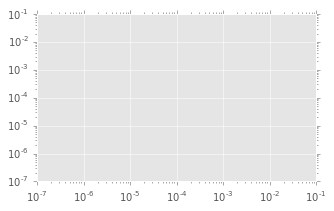

In [7]:
graphs = ["in-2004", "as-skitter", "com-youtube", "belgium", "wiki-topcats"]
prefix_arr = ["prefix01", "prefix03", "prefix05", "prefix10", "prefix30", "prefix50"]
def loadResults(graphPath):
    frame=pd.read_csv(graphPath, header=None)
    return frame

# knl_res_dir = "results-stampede-knl/"
# loadResults(knl_res_dir+graphs[0]+".csv")
    
def scalabilityLRB(coarse, coarselb, prefix,resultsfile,mytitle):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    fig.set_size_inches(5,3)
    axes.set_yscale("log",basey=10)
    axes.set_xscale("log",basey=2)

    
    frame_coarse = loadResults(coarse)
    threads = frame["threads"];
    index = np.arange(len(threads))
    axes.plot(threads, frame["mix-coo"], label="Mixed-EdgeList",color=plt.rcParams['axes.color_cycle'][0],marker=fmarkers[0])
    axes.plot(threads, frame["lrb-scalar"], label="Scalar",color=plt.rcParams['axes.color_cycle'][1],marker=fmarkers[1])
    axes.plot(threads, frame["lrb-vector"], label="Vector",color=plt.rcParams['axes.color_cycle'][2],marker=fmarkers[2])
    axes.plot(threads, frame["lrb-dod-scalar"], label="DOD-Scalar",color=plt.rcParams['axes.color_cycle'][3],marker=fmarkers[3])
    axes.plot(threads, frame["lrb-dod-vector"], label="DOD-Vector",color=plt.rcParams['axes.color_cycle'][4],marker=fmarkers[4])
    plt.title(mytitle)

    plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True, fontsize=12)
    axes.set_ylabel("Execution Time",fontsize=11)    
    axes.set_xlabel("Threads",fontsize=14)    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    plt.savefig(resultsfile+".pdf", format="pdf",bbox_inches='tight');
    plt.savefig(resultsfile+".png", format="png",bbox_inches='tight');
    
    plt.close()
#    

def utiliziationLRB(graphname,resultsfile,mytitle):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    fig.set_size_inches(5,3)
    axes.set_xscale("log",basey=2)

    frame = loadResults(graphname)
    threads = frame["threads"];
    index = np.arange(len(threads))
#     axes.plot(threads, frame["mix-coo"], label="Mixed-EdgeList",color=plt.rcParams['axes.color_cycle'][0],marker=fmarkers[0])
    axes.plot(threads, frame["mix-coo"]/frame["lrb-scalar"], label="Scalar",color=plt.rcParams['axes.color_cycle'][1],marker=fmarkers[1])
    axes.plot(threads, frame["mix-coo"]/frame["lrb-vector"], label="Vector",color=plt.rcParams['axes.color_cycle'][2],marker=fmarkers[2])
    axes.plot(threads, frame["mix-coo"]/frame["lrb-dod-scalar"], label="DOD-Scalar",color=plt.rcParams['axes.color_cycle'][3],marker=fmarkers[3])
    axes.plot(threads, frame["mix-coo"]/frame["lrb-dod-vector"], label="DOD-Vector",color=plt.rcParams['axes.color_cycle'][4],marker=fmarkers[4])
    plt.title(mytitle)

    plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True, fontsize=11)
    axes.set_ylabel("Speedup (over edge list)",fontsize=14)    
    axes.set_xlabel("Threads",fontsize=14)    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.savefig(resultsfile+".pdf", format="pdf",bbox_inches='tight');
    plt.savefig(resultsfile+".png", format="png",bbox_inches='tight');

    plt.close()

def phasesLRB(graphname,resultsfile,mytitle):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    fig.set_size_inches(5,3)
#     axes.set_xscale("log",basey=2)

    frame = loadResults(graphname)
    threads = frame["threads"];
    index = np.arange(len(threads))
    bar_width = 0.8

#     axes.plot(threads, frame["lrb-dod-coo"]/frame["lrb-dod-vector"], label="Vector",color=plt.rcParams['axes.color_cycle'][0],marker=fmarkers[0])
#     axes.plot(threads, frame["dod-load-balance"]/frame["lrb-dod-vector"], label="Scalar",color=plt.rcParams['axes.color_cycle'][1],marker=fmarkers[1])
#     axes.plot(threads, (frame["lrb-dod-vector"] - frame["lrb-dod-coo"] - frame["dod-load-balance"])/frame["lrb-dod-vector"], label="DOD-Scalar",color=plt.rcParams['axes.color_cycle'][2],marker=fmarkers[2])

    plt.bar(index, frame["lrb-dod-coo"]/frame["lrb-dod-vector"], bar_width,label="Edge-List-Creation",color=plt.rcParams['axes.color_cycle'][0])
    plt.bar(index, frame["lrb-dod-load-balance"]/frame["lrb-dod-vector"], bar_width, label="LRB",color=plt.rcParams['axes.color_cycle'][1],bottom= frame["lrb-dod-coo"]/frame["lrb-dod-vector"])
    plt.bar(index, (frame["lrb-dod-vector"] - frame["lrb-dod-coo"] - frame["lrb-dod-load-balance"])/frame["lrb-dod-vector"], bar_width, label="Triange-Counting",color=plt.rcParams['axes.color_cycle'][2],bottom= (frame["lrb-dod-coo"]+frame["lrb-dod-load-balance"])/frame["lrb-dod-vector"])

    
    plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=True, fontsize=11)
    axes.set_ylabel("Ratio of Phases ",fontsize=14)    
    axes.set_xlabel("Threads",fontsize=14)    
    plt.xticks(index, threads,fontsize=11)
    plt.yticks(fontsize=11)
    plt.title(mytitle)
    plt.ylim(0,1)
    plt.savefig(resultsfile+".pdf", format="pdf",bbox_inches='tight');
    plt.savefig(resultsfile+".png", format="png",bbox_inches='tight');

    plt.close()
    
    
for g in graphs:
    #print knl_res_dir_full+g+".csv"
    file_path = g + "/nk256/"
    coarse_path = file_path + g + "_coarse_nk256.csv"
    coarselb_path = file_path + g + "_coarselb_nk256.csv"
    prefix_path = file_path + "prefix/" + g + "_prefix"

    scalabilityLRB(coarse_path, coarselb_path, prefix_path, file_path, g)
    #scalabilityLRB(skx_res_dir_full+g+".csv","plots/time-"+g+"-skx",g)
    #utiliziationLRB(knl_res_dir_full+g+".csv","plots/utilization-"+g+"-knl",g)
    #utiliziationLRB(skx_res_dir_full+g+".csv","plots/utilization-"+g+"-skx",g)
    #phasesLRB(knl_res_dir_full+g+".csv","plots/phases-"+g+"-knl",g)
    #phasesLRB(skx_res_dir_full+g+".csv","plots/phases-"+g+"-skx",g)

    



In [6]:
def edgesPerSecond(graphNames, knl, skx,filename):

    fig, axes = plt.subplots(nrows=1,sharex=True)

    fig.set_size_inches(12,2.5)
    index = np.arange(len(graphNames))
#     plt.gcf().subplots_adjust(bottom=0.1)
    bar_width = 0.45

    plt.bar(index, knl, bar_width, label="KNL-256",color=plt.rcParams['axes.color_cycle'][0])
    plt.bar(index+bar_width, skx, bar_width, label="Skylake-48",color=plt.rcParams['axes.color_cycle'][1])

    plt.yticks(fontsize=9)
    plt.xticks(np.arange(len(graphNames)),graphNames,rotation=graphLabelRotation,fontsize=9)
    plt.legend(loc='upper right', ncol=3, fancybox=True, shadow=True, fontsize=11)

    axes.set_ylabel("Edeges Per Second",fontsize=14)

#     plt.xticks(index,graphList,rotation=graphLabelRotation,fontsize=15)
    plt.savefig(filename+".pdf", format="pdf",bbox_inches='tight');
    plt.savefig(filename+".png", format="png",bbox_inches='tight');
#     plt.close()



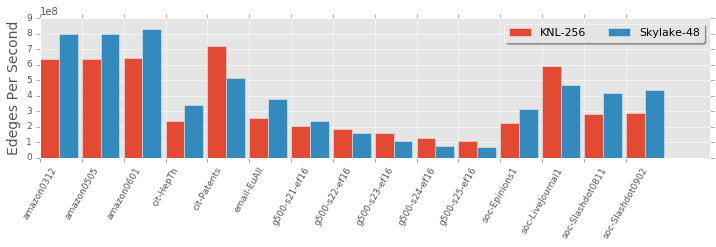

In [11]:
def maxEdgesPerSecond(graphPath):
    frame = loadResults(graphPath);
    frame = frame[frame['threads']>32]
#     print (frame['lrb-dod-vector']).min()
#     print frame
    return (frame["ne"]/frame['lrb-dod-vector']).max()
    

maxEPSListKNL = []
maxEPSListSKX = []
for g in graphList:
#     print g
    max = maxEdgesPerSecond(knl_res_dir+g+".csv") 
    maxEPSListKNL.append(max)
    max = maxEdgesPerSecond(skx_res_dir+g+".csv")
    maxEPSListSKX.append(max)
# print maxEPSListKNL
# print maxEPSListSKX

# print graphList
edgesPerSecond(graphList,maxEPSListKNL,maxEPSListSKX, "plots/edgesPerSecond")

In [7]:
print plt.rcParams['axes.color_cycle'][0]

#E24A33


./results/outputs_old/soc-pokec-relationships_batchtime.txt


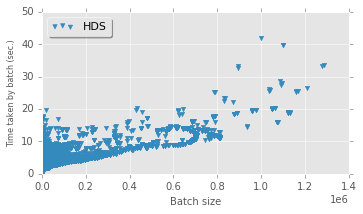

In [37]:

graphs = ["dblp-author", "patentcite", "soc-LiveJournal1", "soc-pokec-relationships", "trackers", "wikipedia_link_de"]
impls = ["new", "old", "park", "igraph"]
exps = ["data", "gpuutil", "batchtime", "edges", "ev_count"]

def loadDataImpl(graph, data_path, impl, exp):
    peels = []
    times = []
    iters = []
    edges = []
    ev_count = []
    gpuutil = []
    batchsize = []
    batchtime = []
    
    file_path = ""
    
    file_path = data_path + "outputs_" + impl + "/" + graph + "_" + "batchtime" + ".txt"
    
    print file_path
    if impl == "new" and (exp == "data" or exp == "ev_count"):
        with open(file_path, "rb") as datafile:
            peel_found = False
            for line in datafile:
                tokens = line.split()
                if "max_peel" in line:
                    peels.append(int(tokens[1]))
                    peel_found = True
                    continue

                if peel_found:
                    if "ms" in line:
                        times.append(float(tokens[len(tokens) - 2]) / 1000.0)
                    elif "iter_count" in line:
                        iters.append(int(tokens[1]))
                    elif "edge_count" in line:
                        edges.append(int(tokens[1]))
                    elif "ev_count" in line:
                        ev_count.append(int(tokens[1]))
                        
    elif impl == "park" and (exp == "data" or exp == "ev_count"):
        with open(file_path, "rb") as datafile:
            peel_found = False
            for line in datafile:
                tokens = line.split()
                if "MAXIMUM" in line:
                    peels.append(int(tokens[len(tokens) - 1]))
                    peel_found = True
                    continue
                
                if "time" in line:
                    times.append(float(tokens[1]) / 1000.0)
                elif "ev_count" in line:
                    ev_count.append(int(tokens[1]))
    elif exp == "gpuutil":
        print "here"
        with open(file_path, "rb") as datafile:
            for line in datafile:
                tokens = line.split()
                if "16280" in line:
                    idx = len(tokens) - 3
                    gpuutil.append(float(tokens[idx].rstrip(u'%')))
    elif exp == "batchtime":
        with open(file_path, "rb") as datafile:
            for line in datafile:
                if "size" in line:
                    tokens = line.split()
                    batchsize.append(int(tokens[1]))
                    idx = len(tokens) - 2
                    batchtime.append(float(tokens[idx]))

    return (peels, times, iters, edges, ev_count, gpuutil, batchsize, batchtime)

def loadData(graph, data_path):
    data_results = dict()
    for impl in impls:
        if impl == "old":
            data_results[impl] = loadDataImpl(graph, data_path, impl, "batchtime")
    return data_results
    
    
def plotData(data_path, graph, mytitle, data):
    fig, axes = plt.subplots(nrows=1,sharex=True)
    fig.set_size_inches(5.5,3)
    #axes.set_xscale("log",basey=2)
    #axes.set_yscale("log",basey=2)

    xcoord = 0
    ycoord = -1
    ylabel = ""
    if data == "peels":
        ycoord = 0
        ylabel = "peels"
    elif data == "data":
        ycoord = 1
        ylabel = "Time (sec.)"
    elif data == "iters":
        ycoord = 2
        ylabel = "Number of iterations in k-core number alg"
    elif data == "edges":
        ycoord = 3
        ylabel = "Edges in k-core"
    elif data == "ev_count":
        ycoord = 4
        ylabel = "Edges and Vertices Accessed"
    elif data == "gpuutil":
        ycoord = 5
        ylabel = "Percentage of GPU Utilized"
    elif data == "batchtime":
        xcoord = 6
        ycoord = 7
        ylabel = "Time taken by batch (sec.)"
    else:
        print "Error in data: " + data
        return
    
    graph_data = dict()
    graph_data[graph] = loadData(graph, data_path)

    
    for exp in exps:
        if exp == "batchtime":
            for g in graphs:
                #if g == "trackers" or g == "wikipedia_link_de":
                if g == graph:
                    for i, impl in enumerate(impls):
                        if impl == "old":
                            if impl == "new":
                                label = "HDO"
                            elif impl == "park":
                                label = "ParK"
                            elif impl == "old":
                                label = "HDS"
                            #print len(graph_data[g][impl][0])
                            #print len(graph_data[g][impl][ycoord])
                            #axes.plot(graph_data[g][impl][0],
                            #xcoords = np.arange(0, len(graph_data[graph][impl][ycoord]) / 2, 0.5) # for gpuutil
                            #xcoords = np.arange(0, 1, 1.0 / float(len(graph_data[graph][impl][ycoord])))
                            #axes.plot(xcoords, 
                            axes.scatter(graph_data[g][impl][xcoord], # for batch time
                                    graph_data[g][impl][ycoord], 
                                      label=label,
                                      color=plt.rcParams['axes.color_cycle'][i],
                                      marker=fmarkers[i])

    axes.set_ylim(ymin=0)
    #axes.set_ylim(ymax=100)

    axes.set_xlim(xmin=0)
    
    #axes.plot(threads, threads, label="Ideal",color=plt.rcParams['axes.color_cycle'][4])
    #axes.set_yticks(np.arange(0, 5.0, 0.5))
    


    #plt.title(mytitle)
    plt.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, fontsize=11)
    
    axes.set_ylabel(ylabel,fontsize=8)    
    axes.set_xlabel("Batch size",fontsize=10)    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    
    #plt.gca().invert_xaxis()
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig(mytitle + ".pdf", format="pdf")
    plt.show()
    plt.close()
    
#plotData("./results/", "trackers", "evcount_per_peel_trackers_" + impl, "ev_count")
#plotData("./results/", "wikipedia_link_de", "times_per_peel_wikide", "data")
#plotData("./results/", "soc-pokec-relationships", "evcount_per_peel_pokec", "times")
#plotData("./results/", "soc-LiveJournal1", "evcount_per_peel_lj", "times")

#plotData("./results/", "patentcite", "gpuutil_v_time_patentcite_hds", "gpuutil")
#plotData("./results/", "patentcite", "gpuutil_v_time_patentcite_hdo", "gpuutil")
plotData("./results/", "soc-pokec-relationships", "batchsize_v_time_pokec", "batchtime")
